# CIFAR-10 이미지 생성 프로젝트

CIFAR-10 데이터셋과 DCGAN 모델구조를 이용해서 색다른 이미지를 생성하는 모델을 만들어보자. 전에 학습한 FASHION-MNIST와 몇 가지 달라지는 점이 있다.   
- image data shape가 (28, 28, 1) -> (32, 32, 3)으로 변경된다.
- 단색의 grayscale이 RGB 3채널의 컬러 이미지로 변경된다.
- 입력데이터 차원이 3~4배 증가하면서 학습 진행되는 양상이 달라진다.

# 1. 작업환경 구성하기

`mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples`   
`mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints`   
`mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history`   

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# 2. 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(train_x.shape)
print(test_x.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


## 2-1. 데이터 살펴보기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


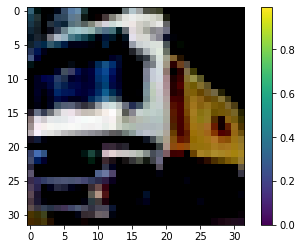

In [5]:
plt.imshow(train_x[1])
plt.colorbar()
plt.show()

train 모델을 정규화 해주면서 [-1, 1] 값을 갖게 되는데 시각화를 하니 `Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).` 에러가 나오면서 색상이 많이 어둡게 나온다. 이를 해결하기 위해 [0, 1] 범위의 값을 갖게 하거나 [0, 255] 범위를 가져야 한다고 한다.

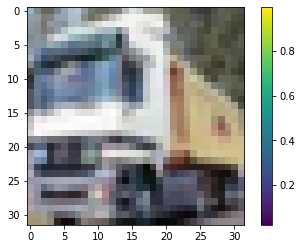

In [6]:
plt.imshow((train_x[1] + 1) / 2)
plt.colorbar()
plt.show()

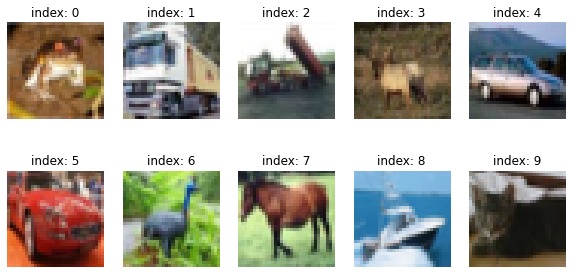

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

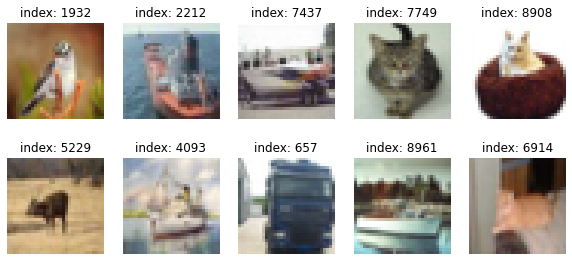

In [8]:
plt.figure(figsize=(10, 12))

for i in range(10):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 10000)
    plt.imshow((train_x[random_index] + 1) / 2)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

# 2-2. 데이터 학습 준비

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

BUFFER_SIZE는 데이터셋을 섞어서 모델에 넣어주고, BATCH_SIZE별로 잘라서 학습을 진행하는 미니 배치 학습이다.

---

이번에 구현할 모델은 GAN에서 개선된 DCGAN 모델이다. 생성자, 판별자라는 두 가지 네트워크에서 서로 경쟁하듯 개선을 유도하는 방식이다. [논문 확인하기](https://arxiv.org/pdf/1406.2661.pdf)   
- 생성자 generator: 의미 없는 랜덤 노이즈로부터 신경망에서 연산을 통해 이미지 형상의 벡터를 생성한다. 
- 판별자 discriminator: 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 real, fake에 대한 판단을 실숫값 정도로 출력한다. 

# 3. 생성자 모델 구현하기

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

Conv2DTranspose는 이미지 사이즈를 넓혀주는 층이다. 이를 세 번 사용해 (8, 8, 256) -> (16, 16, 64) -> (32, 32, 3)의 흐름을 갖게 유도했다.

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

`tf.random.normal`을 사용해서 가우시안 분포에서 뽑아낸 랜덤 노이즈 벡터를 주고 시각화 테스트 해보자.

In [13]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False) # 실제 학습이 아니기 때문에 training=False
generated_image.shape

TensorShape([1, 32, 32, 3])

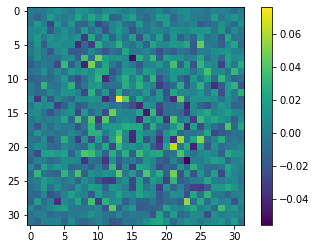

In [14]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# 4. 판별자 모델 구현하기

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

생성자 모델과 반대로 Conv2D를 이용해 이미지 크기를 줄이는 작업을 한다. (32, 32, 3) -> (16, 16, 64) -> (8, 8, 128) 줄이고 Flatten으로 쭉 펴서(1, 8192) 형상의 벡터로 변환해서 Dense로 출력한다.

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00368925]], dtype=float32)>

tensorflow 형태의 형태로 출력이 됐다. 이를 갖고 모델 학습을 진행하는점 참고하자.

# 5. 손실함수와 최적화 함수 구현하기

GAN은 분류 모델을 설계할때 많이 사용하는 손실함수인 cross entropy를 사용한다. 특징으로는 두 값이 얼마나 차이나는지 정량적으로 계산할때 많이 쓰인다. 판별자는 이미지의 진짜, 가짜를 나타내야하기 때문에 binary cross entropy를 사용한다. 생성자와 판별자의 목표를 상기하고 가자.   
- 생성자: 판별자가 fake image를 판별할 때 D값이 1(real image)에 가까워지는것.
- 판별자: real image 판별값 D는 1에, fake image의 D는 0에 가까워지는것.

### 손실함수

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross entropy를 계산하기 위해 판별한 값의 범위를 정해줘야한다. 그래서 위의 함수를 사용하면 0~1 사이의 값으로 정규화해 알맞게 계산할 수 있다. 

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

real, fake output의 accuracy를 따로 계산해서 비교해보자. 가장 이상적인 수치는 초반에 둘 다 1.0에 가깝게 나오다가 서서히 낮아져 0.5에 가까워지는 것이다. fake accuracy가 1.0에 가까우면 생성자가 판별자를 잘 속이지 못하고 있다는 뜻이다.

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위를 해석해보면   
- `tf.math.greater_equal(real_output, tf.constant([0.5])`는 real_output의 값이 0.5 이상인지에 따라 True, False로 계산된다
- `tf.cast(), tf.float32`로 true면 1.0 false면 0.0으로 변환한다. 
- `tf.reduce_mean()`으로 평균을 내어 배치의 정확도를 계산한다.

### 최적화 함수

생성자와 구분자는 따로 학습을 진행하는 개별 네트워크여서 optimizer를 따로 선언해주어야한다.

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # 1e-4는 learning rate를 말한다.
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
# 100차원의 노이즈를 16개 선언
seed.shape

TensorShape([16, 100])

# 6. 훈련과정 상세 기능 구현하기

하나의 미니 배치당 진행할 train_step 함수를 먼저 만들어야한다. 학습시킬 훈련 함수 위에 `@tf.funtion`이라는 데코레이터를 붙여 사용한다. 이는 직접 session을 열어 학습하고 완료되면 닫아주는 번거로운 과정을 내부적으로 처리해 편리하게 만들어준다. [파이썬-데코레이터](https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/)

In [24]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

한번의 train_step이 끝나는 과정을 정리하면 다음과 같다.   

- (1). real image 역할의 images 세트를 입력 받음
- (2). FAKE IMAGE를 생성하기 위한 noise를 images와 같은 크기의 BATCH_SIZE만큼 생성함
- (3). 가중치 갱신을 위한 gradient를 자동 미분으로 계산하기 위해 with로 열기
- (4). generator가 noise를 입력받고 images를 생성하기
- (5). real image인 images, fake image인 generated_images를 입력받아 각각 출력
- (6). 이들을 각각의 loss값 계산
- (7). 그리고 accuracy도 계산
- (8). gen_tape, disc_tape로 gradient 계산
- (9). 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10). 이번 스텝에 계산된 loss, accuracy를 리턴

### train_step 시각화

이미지를 보여주는 방법과 train_step에서 return한 값들을 갖고 시각화 하는 방법으로 진행했다.

In [25]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2) # 역정규화한 상태를 출력하기
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기 15,6

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [27]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 7. 학습 과정 진행하기

위에서 선언한 한 단계 학습하는 `train_step`, 샘플 이미지 저장하는 `generate_and_save_images()`, 학습 과정을 시각화하는 `draw_train_history()`, 모델 저장하기 위한 `checkpoint`을 활용해서 합쳐 학습해보자.

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

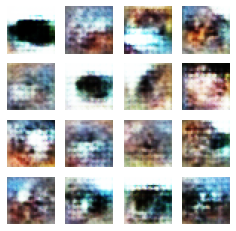

Time for training : 729 sec


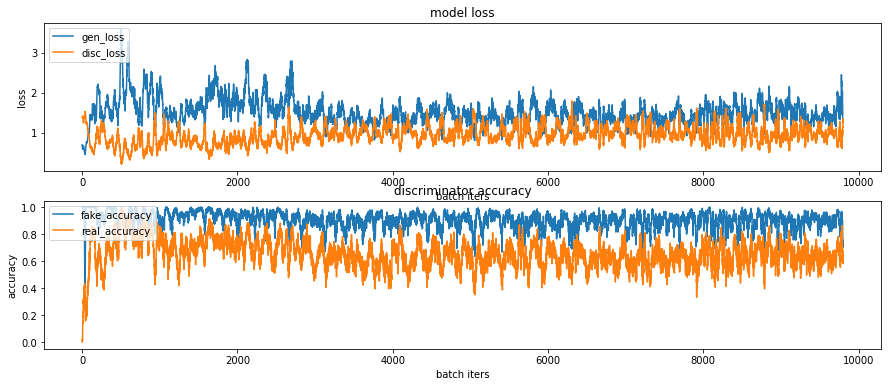

CPU times: user 12min 35s, sys: 1min 19s, total: 13min 55s
Wall time: 12min 10s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성된다.

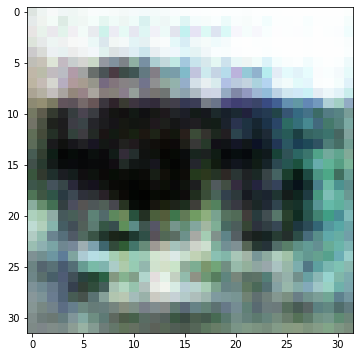

In [31]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [32]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1088356 Feb 15 10:59 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


# 결과 확인하기

![](https://8888-wn75isz0iee8osgrbwmzs5dod.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10/training_history/train_history_0049.png)

![](https://8888-wn75isz0iee8osgrbwmzs5dod.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif)

![](https://8888-wn75isz0iee8osgrbwmzs5dod.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0050_iter_195.png)

__의문점__   
- 맨 처음 데이터를 불러올 때 `(train_x, _), (test_x, _) = cifar10.load_data()` `train_x`와 `test_x`를 불러왔는데 `test_x`를 사용하지 않고 있다. 그렇다면 `train_x`만 불러와도 되는거 아닌가?

결과물을 보면 제대로 학습이 안된것을 볼 수 있다. 어떤 물체인지 확인조차 하기 힘들정도인데, 학습때 진행한 흑백에서 RGB로 채널이 3개나 늘어나다보니 그런거같다. 그렇다면 어떤 부분을 개선할 수 있을까?   

__개선방안__
- 채널이 늘어난만큼 더 학습할 수 있게 생성자, 판별자 모델 레이어에 다양한 요소를 추가해서 깊게 만들어보자.
- 모델의 레이어 하이퍼 파라미터나 최적화 함수 Adam의 learning rate 하이퍼 파라미터를 조정해보자.
- 학습을 더 진행하기 위해 에포크의 수를 늘려보자.

# 8. 개선하기

참고한 사이트   

- __[Tips for Training Stable Generative Adversarial Networks]__(https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- __[How to Develop a GAN to Generate CIFAR10 Small Color Photographs]__(https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

### 8-1. 생성자 모델

In [33]:
def make_generator_improve_model():

    # Start
    model = tf.keras.Sequential()

    # foundation image
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((4, 4, 256)))
    
    # upsampling
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # upsampling
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # upsampling
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [34]:
discriminator = make_generator_improve_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

### 8-2. 판별자 모델

In [35]:
def make_discriminator_improve_model():

    # Start
    model = tf.keras.Sequential()

    # downsampling
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # downsampling
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # downsampling
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # downsampling
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))    
    
    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1))

    return model

In [36]:
discriminator = make_discriminator_improve_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 256)        

### 8-3. 최적화 함수

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

진행 속도를 높이기 위해 learing rate를 1e-4에서 2e-4로 변경했다. 그리고 Adam의 하이퍼파라미터를 보면 3개를 설정할 수 있는데 차례대로 learning rate, 일차 모멘텀, 이차 모멘텀 수치이다. 모멘텀의 default 값은 0.9, 0.999라고 한다. $\beta1$의 momentum 값을 0.5로 감소해서 적용했다.

### 8-4. train_step 선언하기

In [38]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 8-5. 시각화 준비하기

이전에 진행한 데이터와 겹치지 않도록 경로를 새로 생성했다.   
`mkdir -p ~/aiffel/dcgan_newimage/cifar10_1/generated_samples`   
`mkdir -p ~/aiffel/dcgan_newimage/cifar10_1/training_checkpoints`   
`mkdir -p ~/aiffel/dcgan_newimage/cifar10_1/training_history`   

In [39]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2) # 역정규화한 상태를 출력하기
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_1/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [40]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기 15,6

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_1/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [41]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_1/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 8-6. 학습 진행하기

In [42]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_1/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [43]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [44]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

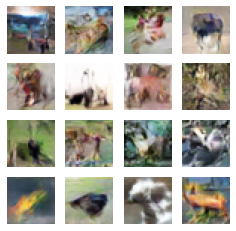

Time for training : 2944 sec


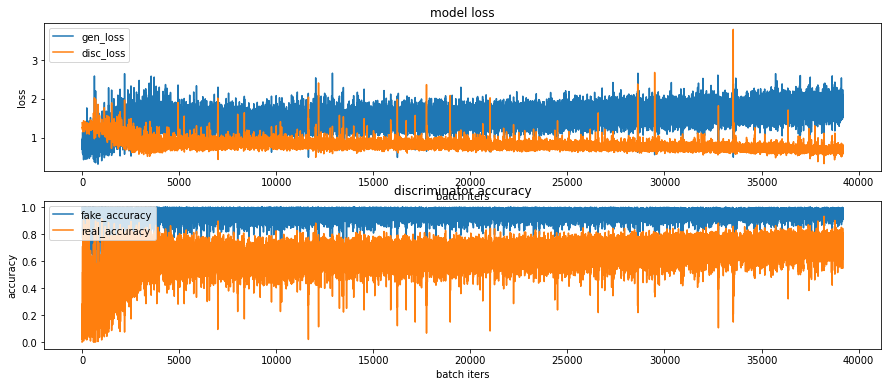

CPU times: user 51min 10s, sys: 5min 22s, total: 56min 32s
Wall time: 49min 6s


In [45]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10_1/training_history 경로에 생성된다.

### 8-7. 결과 확인하기

In [46]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_1/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_1/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1088356 Feb 15 10:59 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


![](https://8888-wn75isz0iee8osgrbwmzs5dod.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10_1/training_history/train_history_0199.png)

![](https://8888-wn75isz0iee8osgrbwmzs5dod.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10_1/cifar10_dcgan.gif)

![](https://8888-wn75isz0iee8osgrbwmzs5dod.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10_1/generated_samples/sample_epoch_0200_iter_195.png)

# 회고

### 모델의 레이어 추가 및 flow 변화   
- 생성자 모델 변화   
upsampling `(8, 8, 256) -> (16, 16, 64) -> (32, 32, 3)` flow를 더 낮은 단계부터 시작하게 `(4, 4, 256) -> (8, 8, 128) -> (16, 16, 128) -> (32, 32, 128) -> (64, 64, 3)` 으로 바꿨다.
- 판별자 모델 변화   
downsampling `(32, 32, 3) -> (16, 16, 64) -> (8, 8, 128) -> (8192)`을 `(32, 32, 3) -> (16, 16, 64) -> (8, 8, 128) -> (4, 4, 128) -> (2, 2, 256) -> (1024)`로 바꿨다.   
생성자, 판별자 둘 다 레이어가 많이 쌓이면 좋은 성능을 내는 특징을 가진 딥러닝의 특성을 활용해서 세세하게 나누기 위해 추가했다.   

> 갑자기 의문이 생겼다. Conv2D 단계에서 이미지 사이즈보다 작게 추출하거나 크게 추출을 설정하면 어떻게 적용될까? 공부할때는 오류가 떠서 진행하지 못한다고 들었는데 이번에 실습하면서 이렇게 적용했다. 만약 작게 슬라이딩하면 추출이 되지 않은 버려진 픽셀들은 그러면 원본 이미지의 우측, 하단 부분일까? 이 부분이 헷갈린다.
- LeakyReLU에 알파값 추가   
deadReLU 부분을 막기 위해 음수에 알파값을 곱한 값을 적용했다. 알파값은 GAN 모델을 훈련할 때 모범 사례의 기본 기울기인 0.2를 적용했다. ~~그런데 LeakyReLU에 알파값을 조절하면 PReLU랑 다른부분이 없지 않나?~~


### 최적화함수의 하이퍼 파라미터 변경
- Adam의 하이퍼 파라미터를 변경했다.   
기존 1e-4에서 2e-4로 learning rate를 키웠고 momentum의 default값인 0.9에서 0.5로 바꾸면서 velocity의 영향력을 크게했다. 두 가지 모두 큰 보폭을 유도했다. 
- 에포크 값 증가   
learning rate를 키워도 좀처럼 학습 상태가 생각보다 좋아지지 않아 에포크 값 자체를 키웠다. ~~학습때 사용한 50에서 2배 늘린 100을 사용했다. 한 가지 아쉬운게 시간 때문에 더 큰 값을 적용하지 못했지만 200정도 넣었을 때 결과값이 어떻게 나올까?~~ 200을 넣고 새로 학습을 돌렸다.

### 후기

- 노이즈 부분에 개선방안이 있지 않을까?   
노이즈를 넣으면 학습할때 의존성 및 오버피팅을 막아주는건 알겠는데, 가우시안 분포를 사용해 노이즈를 선언하는 방법은 처음 알았다. 그렇다면 가우시안 분포가 최적의 방법일까? 다른 방안은 없을까? 하는 의문점이 생겼다. 다른 CNN 프로젝트는 학습 이미지를 돌리거나 늘리거나 자르는 방식으로 많이 적용하는데 비슷하게 학습하면 어떻게 될까?
- gen_loss, disc_loss 의미   
gen_loss와 disc_loss가 가진 의미를 정확하게 모르겠다. 몇번을 다시 생각해봤는데, 이해가 풀리지 않았다. 그냥 loss값 구할때 사용하는구나 하고 넘어갔다.
- check point 아쉬움   
check point를 활용해서 모델을 다시 불러와 학습을 진행했어야 하는데, 사용하지 않고 진행해서 약간 아쉬움이 남았다. 
- 결과값   
새로운 합성이라지만 결과값이 조금 아쉽게 나왔다. 그리고 다 하고나서 알았는데, 위에 학습시킨  모델의 결과물에 이어서 진행되고 있었다. 기존의 변수를 활용하면 짧게 끝낼 수 있을거 같아서 필요한 부분만 재선언하고 나머지는 재선언을 하지 않았는데 이런 결과물이 나왔다.

스터디의 결과가 좋지 않아 스터디를 어떻게 진행하나 많이 막막했다. 그런데 참고 자료 찾다가 사전에 이론을 학습한 부분이 많이 나와서 빠르게 이해하고 적용할 수 있었다. 그래도 처음 gray에서 RGB로 넘어올 때 역정규화를 하지 않아 결과가 형광빛으로 나왔는데 해결하기 위해 시간을 많이 보냈다.